# Exploratory Data Analysis (EDA)

##### Preparacion del dataframe para su analisis


In [1]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats 

##### Rutas json/parquet

In [14]:
steam = pd.read_json('../Dataset_clean/Steam_Games_Limpio.json.gz', compression='gzip')
review = pd.read_json('../Dataset_clean/User_Reviews_Limpio.json.gz', compression='gzip')
items = pq.read_table('Datasets OPS\items.parquet').to_pandas()

In [15]:
# Explotamos los items y normalizamos. Esta combinación de funciones es útil para expandir datos JSON 
# anidados en un DataFrame para que cada elemento se convierta en una fila independiente.
items = items.explode('items', ignore_index=True)
itemsDeUsuario = pd.json_normalize(items['items'])
items.head()

,user_id,items_count,items
0,76561197970982479,277,"{'item_id': '10', 'item_name': 'Counter-Strike..."
1,76561197970982479,277,"{'item_id': '20', 'item_name': 'Team Fortress ..."
2,76561197970982479,277,"{'item_id': '30', 'item_name': 'Day of Defeat'..."
3,76561197970982479,277,"{'item_id': '40', 'item_name': 'Deathmatch Cla..."
4,76561197970982479,277,"{'item_id': '50', 'item_name': 'Half-Life: Opp..."


In [16]:
# borramos las filas donde tienen todos nulos, borramos playtime_2weeks ya que no me da informacion.
itemsDeUsuario.dropna(how='all', inplace=True)
itemsDeUsuario['item_id'] = itemsDeUsuario['item_id'].astype(int)
itemsDeUsuario.drop(columns='playtime_2weeks', inplace=True)

# Preparamos items para hacer un merge con los items ya en forma de dataframe.
items.dropna(subset='items', inplace=True)
items.drop(columns='items',inplace=True)

In [17]:
# Generamos un dataframe con toda la informacion junta, la de reviews al hacer el merge y la de items.
df = review.merge(items, on='user_id', how='left').drop_duplicates()
df.reset_index(drop=True, inplace=True)

items = pd.concat([items, itemsDeUsuario], axis=1)
df = df.merge(items.drop(columns='items_count'), on=['user_id','item_id'])

In [18]:
# Ya unidos los dataframes de items, y review, ahora juntamos con el de steam para tener toda la informacion junta para analisarla.
df = df.merge(steam, left_on='item_id', right_on='id')
df = df.drop(columns=['id','title'])
df[['playtime_forever','items_count']]=df[['playtime_forever','items_count']].astype(int)

In [19]:
# Cambiamos el tipo de recommend de bool a int
df['recommend'] = df['recommend'].astype('int8')
df.head()

,user_id,item_id,recommend,sentiment_analysis,items_count,item_name,playtime_forever,genres,release_date,price,developer
0,76561197970982479,1250,1,2,277,Killing Floor,10006,[Action],2009,19.99,Tripwire Interactive
1,76561197970982479,22200,1,1,277,Zeno Clash,271,"[Action, Indie]",2009,9.99,Ace Team
2,js41637,227300,1,2,888,Euro Truck Simulator 2,551,"[Indie, Simulation]",2013,19.99,Scs Software
3,js41637,239030,1,2,888,"Papers, Please",349,"[Adventure, Indie]",2013,9.99,3909
4,evcentric,248820,1,1,137,Risk of Rain,2328,"[Action, Indie, RPG]",2013,9.99,"Hopoo Games, Llc"


In [20]:
# Expotrtamos para su uso con el modelo de machine learning
df.to_json('EDA\EDA_Dataset.json.gz', compression='gzip')

## Analisis con los datos limpios

### Top juegos con mayor tiempo jugado en Horas (playtime_forever)

In [21]:
# Sacamos las horas del dataframe
juegoMasJugado = df[['item_name','playtime_forever']].groupby('item_name').sum()
# Agarramos el top de juegos, en este caso 5 como ejemplo
juegoMasJugado = juegoMasJugado['playtime_forever'].sort_values(ascending=False).head(5)

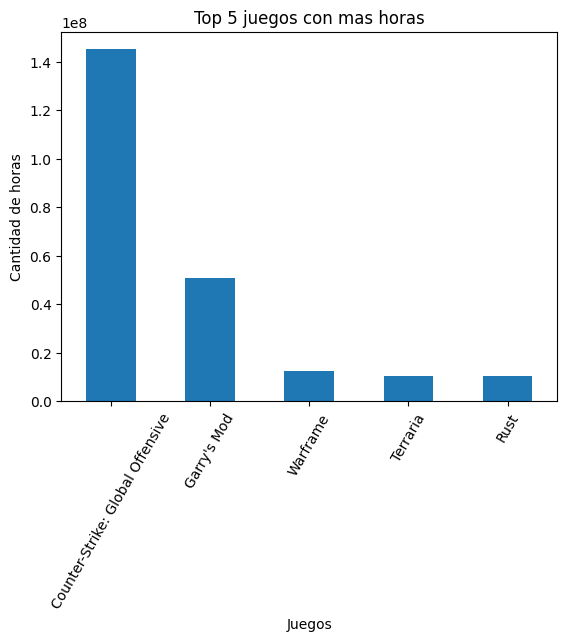

In [35]:
# Creamos un grafico para representar el top de juegos con relacion a sus horas.
juegoMasJugado.plot(kind='bar')
plt.title('Top 5 juegos con mas horas')
plt.xlabel('Juegos')
plt.ylabel('Cantidad de horas')
plt.xticks(rotation=60)
plt.show()

#### Analisis de precio (price)

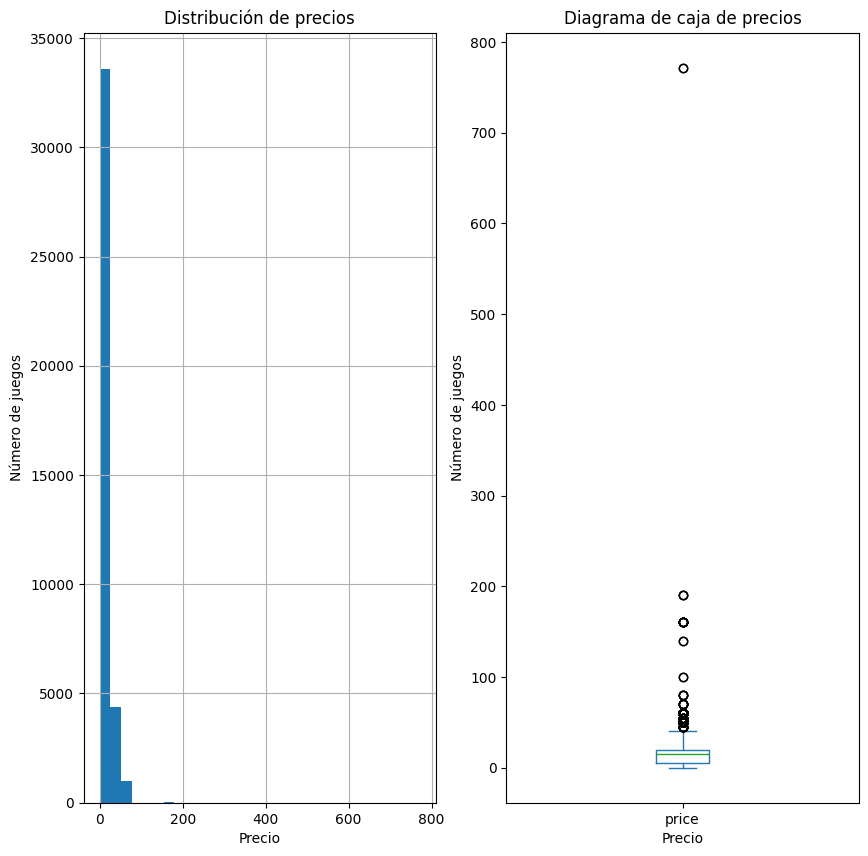

In [55]:
plt.subplot(1,2,1)
df['price'].hist(bins=30, figsize=(10, 10))
plt.title('Distribución de precios')
plt.xlabel('Precio')
plt.ylabel('Número de juegos')

plt.subplot(1,2,2)
df['price'].plot.box()
plt.title('Diagrama de caja de precios')
plt.xlabel('Precio')
plt.ylabel('Número de juegos')

plt.show()

##### Analisis de Generos

In [ ]:
# Agregar del datasets las columnas que necesitamos

#Generos
listaDeGeneros = []
for generos in df['genres']:
  for genero in generos:
    if genero not in listaDeGeneros:
      listaDeGeneros.append(genero)

# Los inicializamos en 0
df[listaDeGeneros] = 0

# +1 al genero si se repite.
for indice, generos in enumerate(df['genres']):
  for genero in generos:
    df[genero].iloc[indice] = 1

#Cambios para ordenar.
generos = []
cantidad = []
for genero in listaDeGeneros:
    generos.append(genero)
    cantidad.append(df[genero].value_counts()[1])

juegos = pd.DataFrame()
juegos['Genero'] = generos
juegos['Cantidad'] = cantidad

##### Juegos por genero

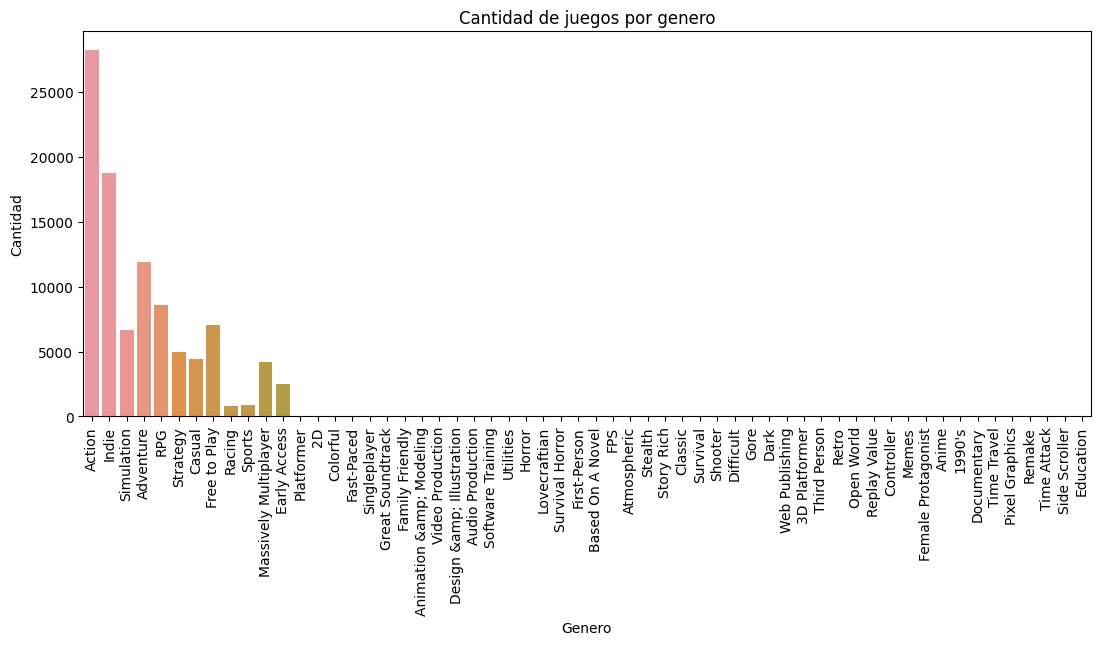

In [70]:
plt.figure(figsize=(13, 5)) 
sns.barplot(data=juegos, x='Genero', y='Cantidad')
plt.title('Cantidad de juegos por genero')
plt.xticks(rotation=90)
plt.show()

##### Top 5 generos mas jugados

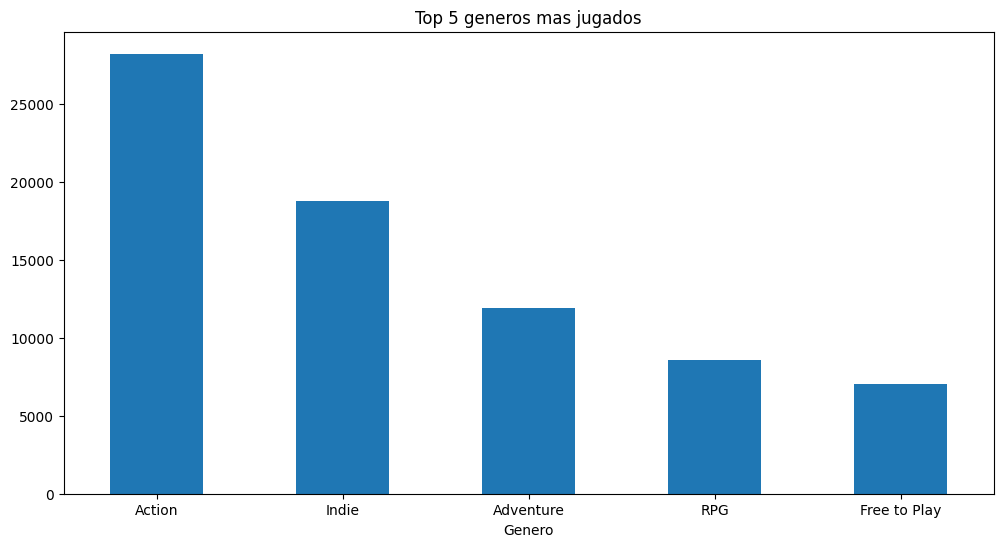

In [71]:
juegos = juegos.groupby('Genero').sum()['Cantidad'].sort_values(ascending=False).head(5)

# Graficamos
plt.figure(figsize=(12, 6)) 
juegos.plot(kind='bar')
plt.title('Top 5 generos mas jugados')
plt.xticks(rotation=0)
plt.show()


df.drop(columns=listaDeGeneros, inplace=True)

##### Cantidad de juegos lanzados por año

In [1]:
juegosPorAño = df['release_date'].value_counts().sort_index()
# Define la paleta de colores que deseas utilizar
juegosPorAño.plot(kind='bar')
plt.title('Cantidad de juegos lanzados por año')
plt.xlabel('Año')
plt.ylabel('Cantidad de juegos')
plt.xticks(rotation=90)
plt.show()

NameError: name 'df' is not defined

##### Recomendaciones

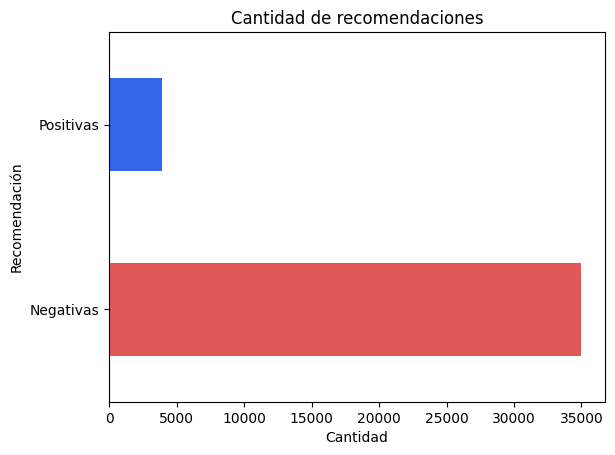

In [101]:
df['recommend'].value_counts().plot(kind='barh', color=['#E05757', '#3366E9'])
plt.title('Cantidad de recomendaciones')
plt.xlabel('Cantidad')
plt.ylabel('Recomendación')
plt.yticks(ticks=[0,1], labels=['Negativas', 'Positivas'])
plt.show()

##### Top 5 juegos mas recomendados

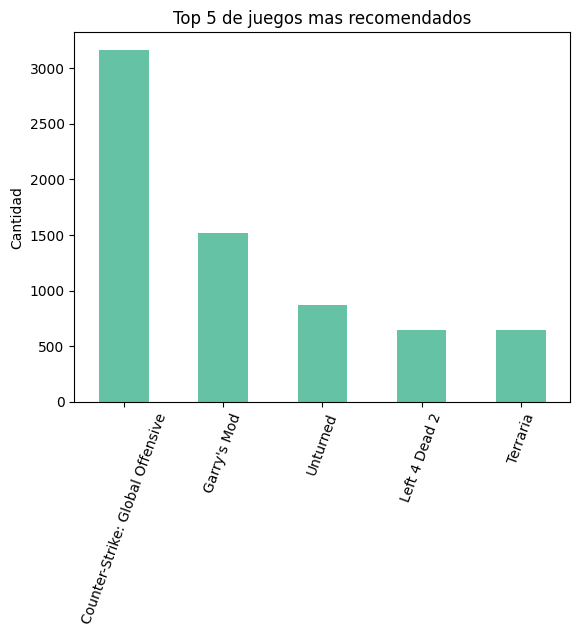

In [107]:
juegosRecomend = df[['item_name', 'recommend']].groupby('item_name')['recommend'].sum().sort_values(ascending=False).head(5)
juegosRecomend.plot(kind='bar')
plt.title('Top 5 de juegos mas recomendados')
plt.ylabel('Cantidad')
plt.xlabel('')
plt.xticks(rotation = 70)
plt.show()

##### Analsis de sentimiento

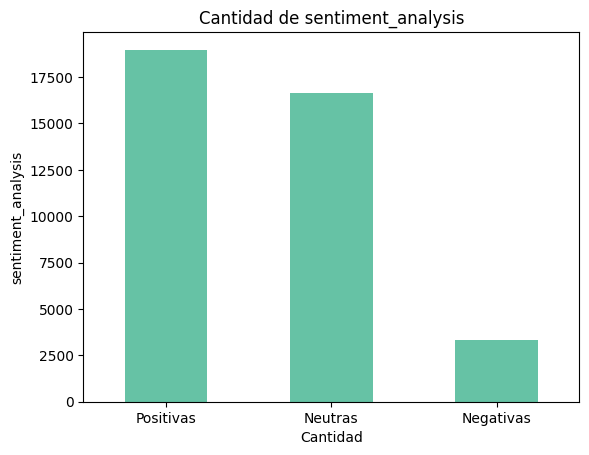

In [108]:
df['sentiment_analysis'].value_counts().plot(kind='bar')
plt.title('Cantidad de sentiment_analysis')
plt.xlabel('Cantidad')
plt.ylabel('sentiment_analysis')
plt.xticks(rotation = 0 ,ticks=[0,1,2],labels=['Positivas','Neutras','Negativas'])
plt.show()

##### Top 5 de juegos con mejor reviews por analisis de sentimiento

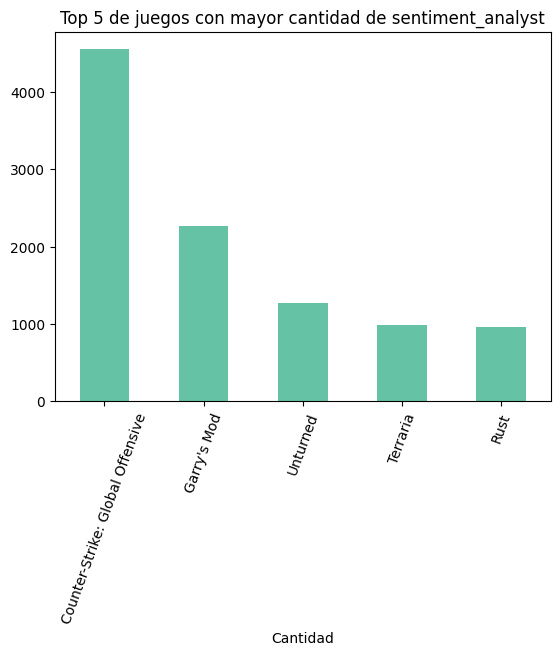

In [110]:
juegosAnalysis = df[['item_name', 'sentiment_analysis']].groupby('item_name')['sentiment_analysis'].sum().sort_values(ascending=False).head(5)
juegosAnalysis.plot(kind='bar')
juegosAnalysis
plt.title('Top 5 de juegos con mayor cantidad de sentiment_analyst')
plt.xlabel('Cantidad')
plt.xticks(rotation = 70)
plt.show()